# Libraries

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

from xgboost import XGBRegressor
from xgboost import plot_importance

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

import time

# Loading the Data

In [2]:
train=pd.read_csv('train.csv',parse_dates=['DateTime'])
test=pd.read_csv('test.csv',parse_dates=['DateTime'])
sub=pd.read_csv('sub.csv')

# Ignoring 2015 Data because we are predicting for months  7,8,9,10 and 2015 data consists of month 11,12 and also Vehicle trend was low during 2015[This Gave us a Boost in Accuracy]. 

In [3]:
train=train[train['DateTime']>='2016-01-01']

In [4]:
train['train_or_test']='train'
test['train_or_test']='test'
df=pd.concat([train,test])

C:\Users\ABetta\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


# Creating Time Based Feature. This helps to convert timeseries problem as regression problem.

In [5]:
def create_date_featues(df):

    df['Year'] = pd.to_datetime(df['DateTime']).dt.year

    df['Month'] = pd.to_datetime(df['DateTime']).dt.month

    df['Day'] = pd.to_datetime(df['DateTime']).dt.day

    df['Dayofweek'] = pd.to_datetime(df['DateTime']).dt.dayofweek

    df['DayOfyear'] = pd.to_datetime(df['DateTime']).dt.dayofyear

    df['Week'] = pd.to_datetime(df['DateTime']).dt.week

    df['Quarter'] = pd.to_datetime(df['DateTime']).dt.quarter 

    df['Is_month_start'] = pd.to_datetime(df['DateTime']).dt.is_month_start

    df['Is_month_end'] = pd.to_datetime(df['DateTime']).dt.is_month_end

    df['Is_quarter_start'] = pd.to_datetime(df['DateTime']).dt.is_quarter_start

    df['Is_quarter_end'] = pd.to_datetime(df['DateTime']).dt.is_quarter_end

    df['Is_year_start'] = pd.to_datetime(df['DateTime']).dt.is_year_start

    df['Is_year_end'] = pd.to_datetime(df['DateTime']).dt.is_year_end

    df['Semester'] = np.where(df['Quarter'].isin([1,2]),1,2)

    df['Is_weekend'] = np.where(df['Dayofweek'].isin([5,6]),1,0)

    df['Is_weekday'] = np.where(df['Dayofweek'].isin([0,1,2,3,4]),1,0)

    #df['Days_in_month'] = pd.to_datetime(df['DateTime']).dt.days_in_month
    
    df['Hour'] = pd.to_datetime(df['DateTime']).dt.hour
    
    #df['Time'] = [((date.hour*60+(date.minute))*60)+date.second for date in df.DateTime]

    return df

In [6]:
df=create_date_featues(df)

# one hot encoding Junction [Gave us a boost]

In [7]:
for col in ['Junction']:
    df = pd.get_dummies(df, columns=[col])

# Getting back train and test

In [8]:
train=df.loc[df.train_or_test.isin(['train'])]
test=df.loc[df.train_or_test.isin(['test'])]
train.drop(columns={'train_or_test'},axis=1,inplace=True)
test.drop(columns={'train_or_test'},axis=1,inplace=True)

C:\Users\ABetta\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


 # Log transforming Vehicle to have normal distribution . [Gave us a boost]

In [9]:
train['Vehicles']=np.log1p(train['Vehicles'])

C:\Users\ABetta\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


# First Validation for time period 2017-1,2,3,4. Since test set contains 4 months data to predict.

In [10]:
train1=train[train['DateTime']<'2017-03-01']
val1=train[train['DateTime']>='2017-03-01']

# Second Validation for time period 2016-7,8,9,10. For the same timeperiod as test data.

In [11]:
newtrain=train[train['DateTime']<'2016-11-01']
train2=train[train['DateTime']<'2016-07-01']
val2=newtrain[newtrain['DateTime']>='2016-07-01']

# Same as second validation ,but including 2017-1,2,3,4 data

In [12]:
newtrain=train[train['DateTime']>='2017-01-01']
train3=pd.concat([train2,newtrain],axis=0)
val3=val2.copy()

In [13]:
def datetounix(df):
    # Initialising unixtime list
    unixtime = []
    
    # Running a loop for converting Date to seconds
    for date in df['DateTime']:
        unixtime.append(time.mktime(date.timetuple()))
    
    # Replacing Date with unixtime list
    df['DateTime'] = unixtime
    return(df)
train1=datetounix(train1)
val1=datetounix(val1)
train2=datetounix(train2)
val2=datetounix(val2)
train3=datetounix(train3)
val3=datetounix(val3)

train=datetounix(train)
test=datetounix(test)

C:\Users\ABetta\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [14]:
x_train1=train1.drop(columns={'ID','Vehicles'},axis=1)
y_train1=train1.loc[:,['Vehicles']]

x_val1=val1.drop(columns={'ID','Vehicles'},axis=1)
y_val1=val1.loc[:,['Vehicles']]

In [15]:
x_train2=train2.drop(columns={'ID','Vehicles'},axis=1)
y_train2=train2.loc[:,['Vehicles']]

x_val2=val2.drop(columns={'ID','Vehicles'},axis=1)
y_val2=val2.loc[:,['Vehicles']]

In [16]:
x_train3=train3.drop(columns={'ID','Vehicles'},axis=1)
y_train3=train3.loc[:,['Vehicles']]

x_val3=val3.drop(columns={'ID','Vehicles'},axis=1)
y_val3=val3.loc[:,['Vehicles']]

# Validating with validation set1.

In [17]:
ts = time.time()

model = XGBRegressor(
    max_depth=8,
    booster = "gbtree",
    n_estimators=100000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,
    seed=42,
    objective='reg:linear')

model.fit(
    x_train1, 
    y_train1, 
    eval_metric="rmse", 
    eval_set=[(x_train1, y_train1), (x_val1, y_val1)], 
    verbose=True, 
    early_stopping_rounds = 100)

time.time() - ts

[10:26:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:2.23535	validation_1-rmse:2.4192
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:2.01856	validation_1-rmse:2.18894
[2]	validation_0-rmse:1.82423	validation_1-rmse:1.97297
[3]	validation_0-rmse:1.65321	validation_1-rmse:1.79658
[4]	validation_0-rmse:1.49337	validation_1-rmse:1.63132
[5]	validation_0-rmse:1.35042	validation_1-rmse:1.49009
[6]	validation_0-rmse:1.22189	validation_1-rmse:1.35935
[7]	validation_0-rmse:1.10677	validation_1-rmse:1.23878
[8]	validation_0-rmse:1.00619	validation_1-rmse:1.13102
[9]	validation_0-rmse:0.91335	validation_1-rmse:1.02881
[10]	validation_0-rmse:0.830033	validation_1-rmse:0.942832
[11]	validation_0-rmse:0.757443	validation_1-rmse:0.859079

[134]	validation_0-rmse:0.207742	validation_1-rmse:0.293987
[135]	validation_0-rmse:0.207667	validation_1-rmse:0.294466
[136]	validation_0-rmse:0.207402	validation_1-rmse:0.294562
[137]	validation_0-rmse:0.207188	validation_1-rmse:0.29449
[138]	validation_0-rmse:0.207161	validation_1-rmse:0.294458
[139]	validation_0-rmse:0.206918	validation_1-rmse:0.294975
[140]	validation_0-rmse:0.206902	validation_1-rmse:0.294418
[141]	validation_0-rmse:0.206752	validation_1-rmse:0.294296
[142]	validation_0-rmse:0.206728	validation_1-rmse:0.294981
[143]	validation_0-rmse:0.206436	validation_1-rmse:0.294487
[144]	validation_0-rmse:0.206284	validation_1-rmse:0.294494
[145]	validation_0-rmse:0.205976	validation_1-rmse:0.294374
[146]	validation_0-rmse:0.205672	validation_1-rmse:0.293617
[147]	validation_0-rmse:0.205476	validation_1-rmse:0.294219
[148]	validation_0-rmse:0.205447	validation_1-rmse:0.293418
[149]	validation_0-rmse:0.205292	validation_1-rmse:0.293419
[150]	validation_0-rmse:0.205207	validati

[272]	validation_0-rmse:0.195942	validation_1-rmse:0.294175
[273]	validation_0-rmse:0.195871	validation_1-rmse:0.293702
[274]	validation_0-rmse:0.195854	validation_1-rmse:0.293719
[275]	validation_0-rmse:0.195785	validation_1-rmse:0.293637
[276]	validation_0-rmse:0.195704	validation_1-rmse:0.2939
[277]	validation_0-rmse:0.195676	validation_1-rmse:0.294337
[278]	validation_0-rmse:0.195637	validation_1-rmse:0.294315
[279]	validation_0-rmse:0.195504	validation_1-rmse:0.294281
[280]	validation_0-rmse:0.195465	validation_1-rmse:0.294028
[281]	validation_0-rmse:0.195313	validation_1-rmse:0.294022
[282]	validation_0-rmse:0.19528	validation_1-rmse:0.294081
[283]	validation_0-rmse:0.195266	validation_1-rmse:0.294339
[284]	validation_0-rmse:0.195249	validation_1-rmse:0.294385
[285]	validation_0-rmse:0.195103	validation_1-rmse:0.294311
[286]	validation_0-rmse:0.195034	validation_1-rmse:0.294496
[287]	validation_0-rmse:0.194865	validation_1-rmse:0.294353
[288]	validation_0-rmse:0.194851	validation

33.85174798965454

In [18]:
pred=model.predict(x_val1)

In [19]:
from sklearn.metrics import mean_squared_error
from math import sqrt
np.sqrt(mean_squared_error(np.expm1(y_val1), np.expm1(pred)))

6.700220427352885

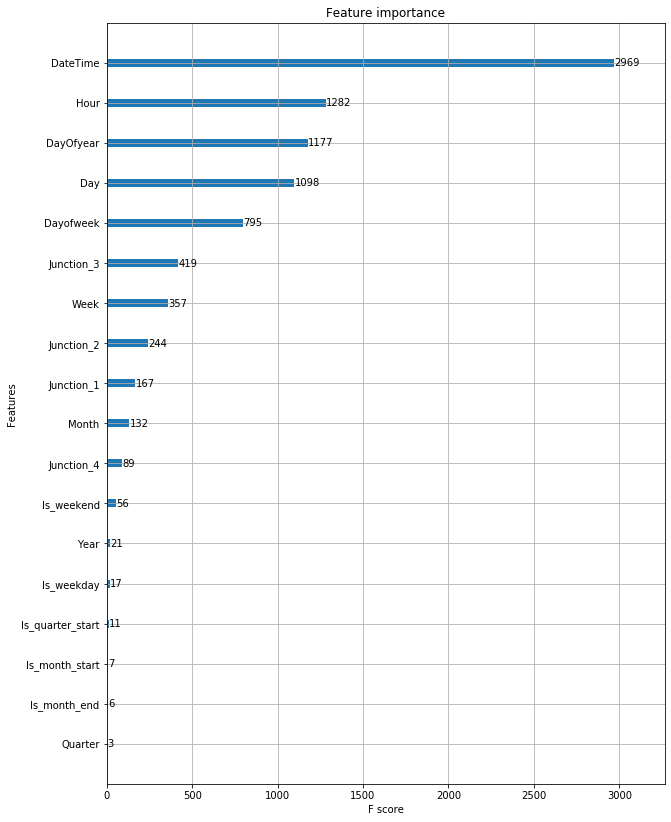

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
plot_features(model, (10,14))

# Validating with validation set 2.

In [23]:
ts = time.time()

model = XGBRegressor(
    max_depth=5,
    n_estimators=10000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.1,    
    seed=42)

model.fit(
    x_train2, 
    y_train2, 
    eval_metric="rmse", 
    eval_set=[(x_train2, y_train2), (x_val2, y_val2)], 
    verbose=True, 
    early_stopping_rounds = 100)

time.time() - ts

[10:27:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:2.08699	validation_1-rmse:2.33282
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:1.88331	validation_1-rmse:2.12799
[2]	validation_0-rmse:1.70033	validation_1-rmse:1.93846
[3]	validation_0-rmse:1.53603	validation_1-rmse:1.77188
[4]	validation_0-rmse:1.38833	validation_1-rmse:1.62643
[5]	validation_0-rmse:1.25766	validation_1-rmse:1.49648
[6]	validation_0-rmse:1.13913	validation_1-rmse:1.37275
[7]	validation_0-rmse:1.03592	validation_1-rmse:1.27116
[8]	validation_0-rmse:0.940793	validation_1-rmse:1.17186
[9]	validation_0-rmse:0.855911	validation_1-rmse:1.08348
[10]	validation_0-rmse:0.780321	validation_1-rmse:1.00342
[11]	validation_0-rmse:0.713227	validation_1-rmse:0.9327

[134]	validation_0-rmse:0.212421	validation_1-rmse:0.42999
[135]	validation_0-rmse:0.212354	validation_1-rmse:0.430124
[136]	validation_0-rmse:0.212235	validation_1-rmse:0.429864
[137]	validation_0-rmse:0.211889	validation_1-rmse:0.4306
[138]	validation_0-rmse:0.211782	validation_1-rmse:0.430467
[139]	validation_0-rmse:0.211463	validation_1-rmse:0.430683
[140]	validation_0-rmse:0.211339	validation_1-rmse:0.430789
[141]	validation_0-rmse:0.211079	validation_1-rmse:0.431384
[142]	validation_0-rmse:0.211035	validation_1-rmse:0.432109
[143]	validation_0-rmse:0.210951	validation_1-rmse:0.432009
[144]	validation_0-rmse:0.210864	validation_1-rmse:0.430875
[145]	validation_0-rmse:0.210805	validation_1-rmse:0.430613
[146]	validation_0-rmse:0.210634	validation_1-rmse:0.430826
[147]	validation_0-rmse:0.210583	validation_1-rmse:0.43104
[148]	validation_0-rmse:0.210532	validation_1-rmse:0.43102
[149]	validation_0-rmse:0.210437	validation_1-rmse:0.431043
[150]	validation_0-rmse:0.210201	validation_1

6.818096160888672

In [24]:
pred=model.predict(x_val2)
sqrt(mean_squared_error(np.expm1(y_val2), np.expm1(pred)))

10.154749846011294

# Validating with validation set 3.

In [25]:
ts = time.time()

model = XGBRegressor(
    max_depth=5,
    n_estimators=10000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.1,    
    seed=42)

model.fit(
    x_train3, 
    y_train3, 
    eval_metric="rmse", 
    eval_set=[(x_train3, y_train3), (x_val3, y_val3)], 
    verbose=True, 
    early_stopping_rounds = 100)

time.time() - ts

[10:27:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:2.25771	validation_1-rmse:2.33069
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:2.03682	validation_1-rmse:2.12439
[2]	validation_0-rmse:1.83835	validation_1-rmse:1.93799
[3]	validation_0-rmse:1.66026	validation_1-rmse:1.76958
[4]	validation_0-rmse:1.50038	validation_1-rmse:1.61703
[5]	validation_0-rmse:1.3569	validation_1-rmse:1.4803
[6]	validation_0-rmse:1.22949	validation_1-rmse:1.35843
[7]	validation_0-rmse:1.11428	validation_1-rmse:1.24897
[8]	validation_0-rmse:1.0108	validation_1-rmse:1.15116
[9]	validation_0-rmse:0.918522	validation_1-rmse:1.06356
[10]	validation_0-rmse:0.836117	validation_1-rmse:0.977442
[11]	validation_0-rmse:0.763453	validation_1-rmse:0.91373
[

[134]	validation_0-rmse:0.214612	validation_1-rmse:0.406355
[135]	validation_0-rmse:0.214569	validation_1-rmse:0.406361
[136]	validation_0-rmse:0.214553	validation_1-rmse:0.406434
[137]	validation_0-rmse:0.214504	validation_1-rmse:0.405996
[138]	validation_0-rmse:0.214313	validation_1-rmse:0.405687
[139]	validation_0-rmse:0.21419	validation_1-rmse:0.405605
[140]	validation_0-rmse:0.21406	validation_1-rmse:0.405603
[141]	validation_0-rmse:0.213972	validation_1-rmse:0.405692
[142]	validation_0-rmse:0.213951	validation_1-rmse:0.407166
[143]	validation_0-rmse:0.21383	validation_1-rmse:0.407045
[144]	validation_0-rmse:0.213786	validation_1-rmse:0.406917
[145]	validation_0-rmse:0.213761	validation_1-rmse:0.406892
[146]	validation_0-rmse:0.213731	validation_1-rmse:0.406883
Stopping. Best iteration:
[46]	validation_0-rmse:0.242368	validation_1-rmse:0.38733



12.159100770950317

In [26]:
pred=model.predict(x_val3)
sqrt(mean_squared_error(np.expm1(y_val3), np.expm1(pred)))

9.956710367699454

#  Model using all train data (except 2015)

In [27]:
x=train.drop(columns={#'DateTime',
    'ID','Vehicles'},axis=1)
y=train.loc[:,['Vehicles']]
test=test.drop(columns={#'DateTime',
    'ID','Vehicles'},axis=1)

In [28]:
model = XGBRegressor(
    max_depth=8,
    n_estimators=220,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,
    
    seed=42)

model.fit(
    x, 
    y)


[10:27:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eta=0.3, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=8, min_child_weight=300, missing=None, n_estimators=220,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
             silent=None, subsample=0.8, verbosity=1)

In [29]:
pred=model.predict(test)
sub['Vehicles']=np.expm1(pred)
sub.to_csv('finalsub.csv',index=False)

In [30]:
# we saved up a couple of steps which gave us further boost, this solution should help to be in top10 ,i will write a detaild kernel in kaggle about the leftout steps.